In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets,transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [4]:
dataset_train = datasets.MNIST(
    '../data_tips',
    train=True,
    download=True,
    transform=transform
)

In [5]:
dataset_valid = datasets.MNIST(
    '../data_tips',
    train=False,
    download=True,
    transform=transform
)

In [6]:
batch_size=1000

In [7]:
dataloader_train = utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

In [8]:
dataloader_valid = utils.data.DataLoader(dataset_valid,batch_size=batch_size,shuffle=True,num_workers=4)

In [9]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
      super(VAE, self).__init__()
      self.x_dim = x_dim
      self.z_dim = z_dim
      self.fc1 = nn.Linear(x_dim, 20)
      self.bn1 = nn.BatchNorm1d(20)
      self.fc2_mean = nn.Linear(20, z_dim)
      self.fc2_var = nn.Linear(20, z_dim)

      self.fc3 = nn.Linear(z_dim, 20)
      self.drop1 = nn.Dropout(p=0.2)
      self.fc4 = nn.Linear(20, x_dim)

    def encoder(self, x):
      x = x.view(-1, self.x_dim)
      x = F.relu(self.fc1(x))
      x = self.bn1(x)
      mean = self.fc2_mean(x)
      log_var = self.fc2_var(x)
      return mean, log_var

    def sample_z(self, mean, log_var):
      epsilon = torch.randn(mean.shape, device="cuda")
      return mean + epsilon * torch.exp(0.5*log_var)

    def decoder(self, z):
      y = F.relu(self.fc3(z))
      y = self.drop1(y)
      y = torch.sigmoid(self.fc4(y))
      return y

    def forward(self, x):
      x = x.reshape(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      z = self.sample_z(mean, log_var)
      y = self.decoder(z)
      return z, y

    def loss_sigmoid(self, x):
      x = x.view(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      delta = 1e-8
      KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
      z = self.sample_z(mean, log_var)
      y = self.decoder(z)
      reconstruction = torch.mean(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))
      lower_bound = [KL, reconstruction]
      return -sum(lower_bound)

In [10]:
model = VAE(x_dim=28*28, z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

VAE(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_mean): Linear(in_features=20, out_features=10, bias=True)
  (fc2_var): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=20, bias=True)
  (drop1): Dropout(p=0.2)
  (fc4): Linear(in_features=20, out_features=784, bias=True)
)

In [11]:

num_epochs = 20
loss_list = []

In [14]:
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      model.zero_grad()
      y, z = model(x)
      loss = model.loss_sigmoid(x)/batch_size
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 0.18260742723941803
EPOCH: 1 loss: 0.014492249116301537
EPOCH: 2 loss: 0.0031146863475441933
EPOCH: 3 loss: 0.001755834324285388
EPOCH: 4 loss: 0.0012589432299137115
EPOCH: 5 loss: 0.0010069035924971104
EPOCH: 6 loss: 0.0008442953112535179
EPOCH: 7 loss: 0.0007209726027213037
EPOCH: 8 loss: 0.0006401570863090456
EPOCH: 9 loss: 0.0006080606253817677
EPOCH: 10 loss: 0.0005409892764873803
EPOCH: 11 loss: 0.0005374319734983146
EPOCH: 12 loss: 0.0004982572281733155
EPOCH: 13 loss: 0.000472503510536626
EPOCH: 14 loss: 0.00047050806460902095
EPOCH: 15 loss: 0.00044222516589798033
EPOCH: 16 loss: 0.00043470418313518167
EPOCH: 17 loss: 0.0004178095841780305
EPOCH: 18 loss: 0.00040721253026276827
EPOCH: 19 loss: 0.0003929458907805383


<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

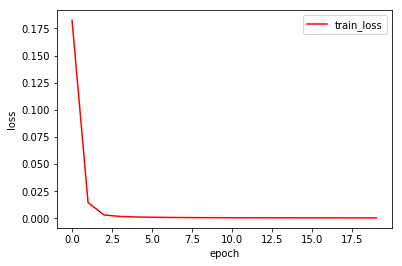

In [15]:
plt.figure()
plt.plot(range(num_epochs),loss_list,'r-',label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 10000

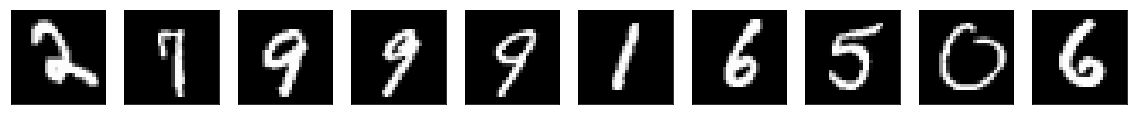

In [22]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')

    x = x.to(device)
    y, z = model(x)
    zs.append(z)
    for i, im in enumerate(y.view(-1, 28, 28).cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    
    z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(10, 10)
    y2 = model._decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()[:20]):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break